In [ ]:
import pandas as pd
from IPython.display import clear_output
import io
import os
import glob
import numpy as np
import random as python_random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,BatchNormalization, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.metrics import roc_auc_score, roc_curve, auc

from cxr_foundation import embeddings_data

seed=19

np.random.seed(seed)
python_random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
mimic_train=pd.read_csv("./Extracted_Embeddings/mimic_train_df.csv")
mimic_validation=pd.read_csv("./Extracted_Embeddings/mimic_validation_df.csv")
mimic_test=pd.read_csv("./Extracted_Embeddings/mimic_test_df.csv")

In [ ]:
data_df=pd.concat([mimic_train,mimic_validation,mimic_test],axis=0,ignore_index=True)

In [ ]:
data_df.path[0]

'files/p14/p14174495/s51234155/2404c1ab-a3b40cde-0c825331-769edf1e-2d99b2cf.tfrecord'

In [ ]:
# Local path
data_df['path'] = "./Extracted_Embeddings/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/"+data_df['path']


In [ ]:
print(data_df.path[0])

./Extracted_Embeddings/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/files/p14/p14174495/s51234155/2404c1ab-a3b40cde-0c825331-769edf1e-2d99b2cf.tfrecord


In [ ]:
data_df.shape

(227641, 23)

In [ ]:
data_df.split.value_counts()

split
train       182896
validate     23154
test         21591
Name: count, dtype: int64

In [ ]:
data_df.insurance.value_counts()

insurance
Other       107228
Medicare    101722
Medicaid     18691
Name: count, dtype: int64

In [ ]:
data_df.split.value_counts(normalize=True)

split
train       0.803441
validate    0.101713
test        0.094847
Name: proportion, dtype: float64

In [ ]:
data_df.split.value_counts()

split
train       182896
validate     23154
test         21591
Name: count, dtype: int64

In [ ]:
data_df['path'] = data_df['path'].apply(str)
data_df['subject_id'] = data_df['subject_id'].apply(str)

data_df['study_id'] = data_df['study_id'].apply(str)
data_df['dicom_id'] = data_df['dicom_id'].apply(str)
data_df['split'] = data_df['split'].astype('category')


In [ ]:
data_df['race']=data_df['race'].replace({'WHITE':'White','BLACK/AFRICAN AMERICAN':'Black','HISPANIC/LATINO':'Hispanic',
                                         'OTHER':'Other','ASIAN':'Asian','AMERICAN INDIAN/ALASKA NATIVE':'AMERICAN INDIAN/ALASKA NATIVE'})

In [ ]:

data_df = data_df[data_df.race .isin(['White','Asian','Black'])]

In [ ]:
# Define the class names (replace with your actual class names)
class_names = data_df['race'].unique()

In [ ]:
data_df.race.value_counts()

race
White    150364
Black     36572
Asian      7390
Name: count, dtype: int64

# Preparing Embeddings Files for Model Training

We want to detect race of a patient using the embeddings with this label.

In [ ]:
df_train = data_df[data_df["split"] == "train"]
df_validate = data_df[data_df["split"] == "validate"]
df_test = data_df[data_df["split"] == "test"]

In [ ]:
print(len(df_train)+len(df_validate))

175373


In [ ]:
print(len(df_test))

18953


In [ ]:
label_encoder = LabelEncoder()
df_train['race'] = label_encoder.fit_transform(df_train['race'])
df_validate['race'] = label_encoder.fit_transform(df_validate['race'])
df_test['race'] = label_encoder.fit_transform(df_test['race'])

C:\Users\gebre\AppData\Local\Temp\ipykernel_12280\4209739039.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['race'] = label_encoder.fit_transform(df_train['race'])
C:\Users\gebre\AppData\Local\Temp\ipykernel_12280\4209739039.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_validate['race'] = label_encoder.fit_transform(df_validate['race'])
C:\Users\gebre\AppData\Local\Temp\ipykernel_12280\4209739039.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [ ]:
y_train_encoded = label_encoder.fit_transform(df_train.race)
y_val_encoded = label_encoder.transform(df_validate.race)
y_test_encoded = label_encoder.transform(df_test.race)

In [ ]:
num_classes=len(class_names)
num_classes

3

In [ ]:
# Convert integer labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val_encoded, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=num_classes)

In [ ]:
# Create training and validation Datasets
training_data = embeddings_data.get_dataset(filenames=df_train.path.values,
                        labels=y_train_one_hot)

validation_data = embeddings_data.get_dataset(filenames=df_validate.path.values,
                        labels=y_val_one_hot)
test_data = embeddings_data.get_dataset(filenames=df_test.path.values,
                        labels=y_test_one_hot)

In [ ]:
for _train in training_data.take(2):
    print(_train)

(<tf.Tensor: shape=(1376,), dtype=float32, numpy=
array([-0.8899373, -0.7238064,  0.6096619, ..., -1.0742147,  0.552022 ,
       -1.1484494], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>)
(<tf.Tensor: shape=(1376,), dtype=float32, numpy=
array([-1.2096279 , -1.2627047 ,  0.573153  , ..., -1.3845499 ,
        0.89542544,  0.05854055], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>)


In [ ]:
for _validation in validation_data.take(2):
  print(_validation)

(<tf.Tensor: shape=(1376,), dtype=float32, numpy=
array([-0.04722768, -2.2200613 ,  0.79090464, ...,  0.3898869 ,
        0.66962755, -0.33819684], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>)
(<tf.Tensor: shape=(1376,), dtype=float32, numpy=
array([-0.24736385, -1.2518303 ,  1.3279704 , ..., -0.50830483,
        1.8371172 , -1.3065869 ], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>)


In [ ]:
for _test in test_data.take(2):
  print(_test)

(<tf.Tensor: shape=(1376,), dtype=float32, numpy=
array([ 0.12077017, -1.2427995 ,  1.5837867 , ..., -0.5301808 ,
        1.6034485 , -0.7398392 ], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 0.], dtype=float32)>)
(<tf.Tensor: shape=(1376,), dtype=float32, numpy=
array([ 0.4763338 , -1.3996319 ,  1.7271736 , ..., -0.51695174,
        1.1214144 , -1.1303827 ], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 1.], dtype=float32)>)


# Create and Train Model

In [ ]:
embeddings_size=1376
learning_rate=0.001
batch_size = 128
epochs = 50
end_lr_factor=1.0
dropout_rate=0.2
decay_steps=1000
loss_weights=None
weight_decay = 0.001
hidden_layer_sizes = [256, 128, 64]
#hidden_layer_sizes = [32, 16]

In [ ]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
from tensorflow.keras.metrics import Accuracy

# ...

# Define a function to build the model
def build_model():

  # Define the input layer
  inputs = Input(shape=(embeddings_size,))

  # Build the model using the Functional API
  hidden = inputs
  for size in hidden_layer_sizes:
    hidden = Dense(size,
                   activation='relu',
                   kernel_initializer=HeUniform(),
                   kernel_regularizer=tf.keras.regularizers.l2(l2=weight_decay),
                   bias_regularizer=tf.keras.regularizers.l2(l2=weight_decay))(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Dropout(dropout_rate)(hidden)

  output = Dense(num_classes, activation='softmax', kernel_initializer=HeUniform())(hidden)

  # Create the model
  model = Model(inputs=inputs, outputs=output)

  # Compile the model with accuracy and AUC as metrics
  model.compile(
      optimizer=Adam(learning_rate=learning_rate),
      loss='categorical_crossentropy',
      metrics=[AUC()])

  return model

model = build_model()


In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
# train the model
history=model.fit(
    x=training_data.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache(),
    validation_data=validation_data.batch(batch_size).cache(),
    callbacks=[early_stopping],
    epochs=epochs,
)

Epoch 1/50
   1109/Unknown - 267s 239ms/step - loss: 1.0115 - auc: 0.9200

## Prepare test dataset and evaluate model performance

In [ ]:
# Evaluate using ROC-AUC
y_pred_prob = model.predict(test_data.batch(batch_size))
y_pred_prob[0]

149/149 [==============================] - 23s 153ms/step


array([0.00387014, 0.78975964, 0.20637017], dtype=float32)

In [ ]:
# Calculate ROC-AUC for each class
n_classes = y_pred_prob.shape[1]  # Number of classes
n_classes

3

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

In [ ]:

for class_idx in range(n_classes):
    # Extract true labels and predicted probabilities for the current class
    y_true = y_test_one_hot[:, class_idx]
    y_prob = y_pred_prob[:, class_idx]

    # Calculate ROC-AUC for the current class
    fpr[class_idx], tpr[class_idx], _ = roc_curve(y_true, y_prob)
    roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])


In [ ]:
roc_auc

{0: 0.873792407143291, 1: 0.8849023453954654, 2: 0.8758045675432011}

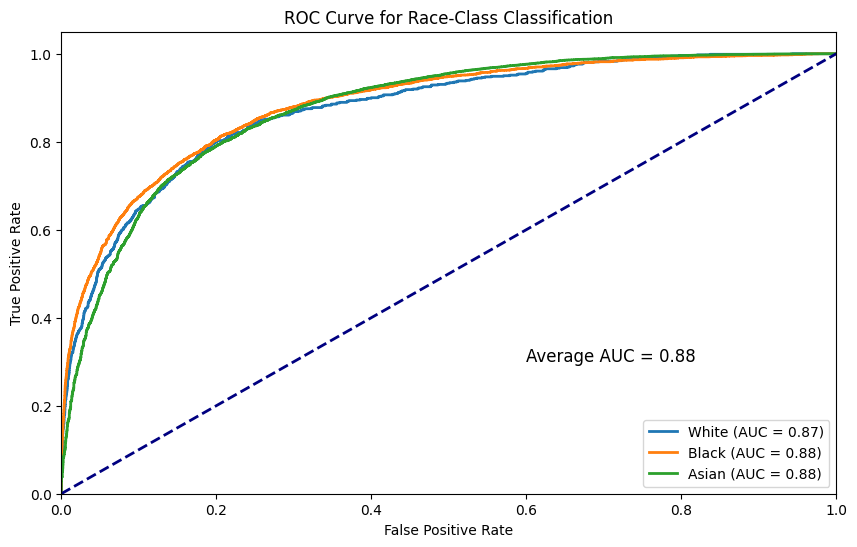

In [ ]:
# Plot ROC Curves for each class
plt.figure(figsize=(10, 6))
for class_idx in range(n_classes):
  plt.plot(fpr[class_idx], tpr[class_idx], lw=2, label=f'{class_names[class_idx]} (AUC = {roc_auc[class_idx]:.2f})')

# Calculate and display the average AUC score
average_auc = np.mean(list(roc_auc.values()))
plt.text(0.6, 0.3, f'Average AUC = {average_auc:.2f}', fontsize=12)

# Plot the diagonal line for reference (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Race-Class Classification')
plt.legend(loc='lower right')
plt.show()